# initial

In [1]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import imageio
from albumentations import HorizontalFlip, VerticalFlip, Rotate
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
""" Create a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [4]:
def load_data(path):
    train_x = glob(os.path.join( path,"new_data02","train", "training_images", "*.png"))
    train_y = glob(os.path.join( path,"new_data02","train", "training_masks", "*.png"))

    test_x = glob(os.path.join( path,"new_data02","validation",'valid_images', "*.png"))
    test_y = glob(os.path.join( path,"new_data02","validation",'valid_masks', "*.png"))

    # test_y = sorted(glob(os.path.join(path, "test", "1st_manual", "*.gif")))
    #returning images and masks
    return (train_x, train_y), (test_x,test_y)

In [5]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)

    """ Load the data """
    data_path='/content/drive/MyDrive/ravir_seg'
    (train_x, train_y), (test_x, test_y) = load_data(data_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Test: {len(test_x)} - {len(test_y)}")

Train: 19 - 19
Test: 4 - 4


In [6]:
""" Seeding the randomness. """
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True



In [7]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [ ]:
#funtion to augment the masks
def augment_data(images, masks, save_path, augment=True):
    size = (512, 512)

    for idx, (x, y) in tqdm(enumerate(zip(images, masks)), total=len(images)):
        """ Extracting the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading image and mask """
        x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
        y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        # y = imageio.mimread(y)[0]

        if augment == True:
            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

            aug = VerticalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented["image"]
            y2 = augmented["mask"]

            aug = Rotate(limit=45, p=1.0)
            augmented = aug(image=x, mask=y)
            x3 = augmented["image"]
            y3 = augmented["mask"]

            X = [x, x1, x2, x3]
            Y = [y, y1, y2, y3]

        else:
            X = [x]
            Y = [y]

        index = 0
        for i, m in zip(X, Y):
            i = cv2.resize(i, size)
            m = cv2.resize(m, size)

            tmp_image_name = f"{name}_{index}.png"
            tmp_mask_name = f"{name}_{index}.png"

            image_path = os.path.join(save_path, "image", tmp_image_name)
            mask_path = os.path.join(save_path, "mask", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            index += 1

# model

In [19]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [20]:
def dice_coefficient(pred, target):
    smooth = 1e-5
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice_score = (2.0 * intersection + smooth) / (union + smooth)
    return dice_score

In [21]:
def dice_loss(pred, target):
    smooth = 1e-5
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() + smooth
    dice = (2.0 * intersection + smooth) / union
    return 1.0 - dice

criterion = dice_loss

In [22]:
def iou_loss(pred, target):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    return 1.0 - iou

criterion = iou_loss

In [23]:
# preprocessing the images
class RavirDataset_2OP(Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], cv2.IMREAD_GRAYSCALE)
        # image= cv2.resize(image, (256, 256), interpolation=cv2.INTER_NEAREST)
        image = image/255.0 ## (512, 512, 3)
        image = np.expand_dims(image, axis=0)
        # image = np.transpose(image, (2, 0, 1))  ## (3, 512, 512)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        """ Reading mask """
        mask= cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        # mask= cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        #binary masks
        bi_mask = mask/255.0
        bi_mask[bi_mask == 0] = 0
        bi_mask[bi_mask == 1] = 1 #white
        bi_mask[(bi_mask > 0) & (bi_mask < 1)] = 1   ## (512, 512)
        bi_mask = np.expand_dims(bi_mask, axis=0) ## (1, 512, 512)
        bi_mask = bi_mask.astype(np.float32)
        bi_mask = torch.from_numpy(bi_mask)

        #tri masks
        tri_mask = mask/255.0
        tri_mask[tri_mask == 0] = 0
        tri_mask[tri_mask == 1] = 1 #white
        tri_mask[(tri_mask > 0) & (tri_mask < 1)] = 0.5   ## (512, 512)
        tri_mask = np.expand_dims(tri_mask, axis=0) ## (1, 512, 512)
        tri_mask = tri_mask.astype(np.float32)
        tri_mask = torch.from_numpy(tri_mask)

        #3 class mask
        mask_v = mask/255.0
        mask_v[mask_v == 0] = 0
        mask_v[mask_v == 1] = 0 #white
        mask_v[(mask_v > 0) & (mask_v < 1)] = 1 #gray
        mask_v = np.expand_dims(mask_v, axis=0) ## (1, 512, 512)
        mask_v = mask_v.astype(np.float32)
        # mask_v = torch.from_numpy(mask_v).long()
        mask_v = torch.from_numpy(mask_v)

        mask_b = mask/255.0
        mask_b[mask_b == 0] = 0
        mask_b[mask_b == 1] = 1 #white
        mask_b[(mask_b > 0) & (mask_b < 1)] = 0 #gray
        mask_b = np.expand_dims(mask_b, axis=0) ## (1, 512, 512)
        mask_b = mask_b.astype(np.float32)
        # mask_b = torch.from_numpy(mask_b).long()
        mask_b = torch.from_numpy(mask_b)

        return image,bi_mask, tri_mask, mask_v,mask_b

In [24]:
# Define the U-Net architecture for binary masks
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1,
                              #  bias=torch.zeros(out_c, dtype=torch.long)
                               )
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1,
                              #  bias=torch.zeros(out_c, dtype=torch.long)
                               )
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x


In [25]:
import torch
import torch.nn as nn

# Define the ResidualBlock
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.stride != 1 or residual.shape[1] != out.shape[1]:
            residual = self.conv1(residual)
            residual = self.bn1(residual)

        out += residual
        out = self.relu(out)

        return out

In [26]:
#first UNet model
class BinaryUNet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(1, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)
        outputs = torch.sigmoid(outputs)
        # outputs = nn.sigmoid(outputs)

        return outputs

In [20]:
#UNET model with 3 decoders
class UNet_DeepComplex4(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(2, 32)
        self.e2 = encoder_block(32,64)
        self.e3 = encoder_block(64,128)
        self.e4 = encoder_block(128,256)
        self.e5 = encoder_block(256,512)
        self.e6 = encoder_block(512,1024)   # Add more encoder blocks

        """ Bottleneck """
        self.b1 = ResidualBlock(1024, 2048)
        self.b2 = ResidualBlock(2048, 2048)
        self.b3 = ResidualBlock(2048, 2048)

        """ Decoder """
        self.d11 = decoder_block(2048, 1024)
        self.d12 = decoder_block(1024, 512)
        self.d13 = decoder_block(512, 256)
        self.d14 = decoder_block(256, 128)
        self.d15 = decoder_block(128, 64)
        self.d16 = decoder_block(64,32)

        self.d21 = decoder_block(2048, 1024)
        self.d22 = decoder_block(1024, 512)
        self.d23 = decoder_block(512, 256)
        self.d24 = decoder_block(256, 128)
        self.d25 = decoder_block(128, 64)
        self.d26 = decoder_block(64,32)

        self.d31 = decoder_block(2048, 1024)
        self.d32 = decoder_block(1024, 512)
        self.d33 = decoder_block(512, 256)
        self.d34 = decoder_block(256, 128)
        self.d35 = decoder_block(128, 64)
        self.d36 = decoder_block(64,32)

        """ Classifier """
        self.outputs1 = nn.Conv2d(32, 1, kernel_size=1, padding=0)
        self.sigmoid1 = nn.Sigmoid()

        self.outputs2 = nn.Conv2d(32, 1, kernel_size=1, padding=0)
        self.sigmoid2 = nn.Sigmoid()

        self.outputs3 = nn.Conv2d(32, 3, kernel_size=1, padding=0)
        # self.softmax = nn.Softmax(dim=1)
        self.tanh = torch.tanh

    def forward(self, inputs, binary_mask):
        inputs = torch.cat((inputs, binary_mask), dim=1)
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        s5, p5 = self.e5(p4)
        s6, p6 = self.e6(p5)

        """ Bottleneck """
        b1 = self.b1(p6)
        b2 = self.b2(b1)
        b3 = self.b3(b2)

        """ Decoder """
        d11 = self.d11(b3, s6)
        d12 = self.d12(d11, s5)
        d13 = self.d13(d12, s4)
        d14 = self.d14(d13, s3)
        d15 = self.d15(d14, s2)
        d16 = self.d16(d15, s1)

        d21 = self.d21(b3, s6)
        d22 = self.d22(d21, s5)
        d23 = self.d23(d22, s4)
        d24 = self.d24(d23, s3)
        d25 = self.d25(d24, s2)
        d26 = self.d26(d25, s1)

        d31 = self.d31(b3, s6)
        d32 = self.d32(d31, s5)
        d33 = self.d33(d32, s4)
        d34 = self.d34(d33, s3)
        d35 = self.d35(d34, s2)
        d36 = self.d36(d35, s1)

        outputs1 = self.outputs1(d16)
        outputs1 = self.sigmoid1(outputs1)

        outputs2 = self.outputs2(d26)
        outputs2 = self.sigmoid2(outputs2)

        outputs3 = self.outputs2(d36)
        outputs3 = self.tanh(outputs3)

        return outputs1, outputs2, outputs3


In [ ]:
if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Directories """
    create_dir("/content/drive/MyDrive/ravir_seg/files1")

    """ Load dataset """
    train_x = sorted(glob("/content/drive/MyDrive/ravir_seg/data01/resz/train/image/*"))
    train_y = sorted(glob("/content/drive/MyDrive/ravir_seg/data01/resz/train/mask/*"))
    valid_x = sorted(glob("/content/drive/MyDrive/ravir_seg/data01/resz/test_no_aug/image/*"))
    valid_y = sorted(glob("/content/drive/MyDrive/ravir_seg/data01/resz/test_no_aug/mask/*"))

    data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
    print(data_str)

    """ Hyperparameters """
    H = 512
    W = 512
    size = (H, W)
    batch_size = 3
    epochs = 50
    lr = 1e-4

    """ Dataset and loader """
    train_dataset = RavirDataset_2OP(train_x, train_y)
    valid_dataset = RavirDataset_2OP(valid_x, valid_y)

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    binary_unet_1 = BinaryUNet().to(device)
    binary_unet = UNet_DeepComplex4().to(device)

    optimizer=optim.Adam(list(binary_unet.parameters()))

    class_weights = torch.ones(3).to(device)
    binary_criterion0 = nn.BCELoss()

    binary_criterion1=nn.BCELoss()
    binary_criterion2=nn.BCELoss()
    # criterion1 = FocalLoss(gamma=2)
    # criterion2 = FocalLoss(gamma=2)
    criterion1 = dice_loss
    criterion2 = dice_loss
    criterion3=iou_loss
    criterion4=iou_loss

    triclass_criterion = nn.MSELoss()

    best_total_loss = float('inf')
    best_binary_loss = float('inf')
    best_valid_loss = float("inf")
    # Training loop
    for epoch in range(epochs):
        print('Epoch number:',epoch)
        start_time = time.time()

        wt= 1-(0.1*epoch)

        binary_unet_1.train()
        binary_unet.train()

        for image,bi_mask, tri_mask, mask_v,mask_b in train_loader:
            image=image.to(device)
            bi_mask=bi_mask.to(device)
            tri_mask=tri_mask.to(device)
            mask_v=mask_v.to(device)
            mask_b=mask_b.to(device)

            # cascading the 2 unet models
            binary_output=binary_unet_1(image)
            binary_loss = binary_criterion0(binary_output, bi_mask)

            binary_output_1,binary_output_2, recon = binary_unet(image, binary_output)
            binary_loss_v1 = binary_criterion2(binary_output_1, mask_v)
            binary_loss_b1 = binary_criterion1(binary_output_2, mask_b)

            binary_loss_v2 = criterion2(binary_output_1, mask_v)
            binary_loss_b2 = criterion1(binary_output_2, mask_b)

            recon_loss = triclass_criterion(recon, image)


            binary_loss_v=binary_loss_v1+binary_loss_v2
            binary_loss_b=binary_loss_b1+binary_loss_b2
            optimizer.zero_grad()

            total_loss= binary_loss+binary_loss_v+binary_loss_b + recon_loss
            total_loss.backward()
            optimizer.step()

        # Validation phase
        binary_unet_1.eval()
        binary_unet.eval()
        binary_loss_total = 0.0
        binary_correct = 0
        total_samples = 0

        with torch.no_grad():
            all_val_loss = 0.0
            binary_val_loss=0.0
            for image, tri_mask, mask_v,mask_b in valid_loader:

                image=image.to(device)
                tri_mask=tri_mask.to(device)
                mask_v=mask_v.to(device)
                mask_b=mask_b.to(device)

                batch_size = image.size(0)
                total_samples += batch_size

                binary_output=binary_unet_1(image)
                binary_val_loss = binary_criterion0(binary_output, bi_mask)

                binary_output_1,binary_output_2, recon = binary_unet(image, binary_output)

                binary_loss_v1 = binary_criterion2(binary_output_1, mask_v).item()
                binary_loss_b1 = binary_criterion1(binary_output_2, mask_b).item()

                binary_loss_v2 = criterion2(binary_output_1, mask_v).item()
                binary_loss_b2 = criterion1(binary_output_2, mask_b).item()

                recon_loss = triclass_criterion(recon, image).item()

                binary_loss_v=binary_loss_v1+binary_loss_v2
                binary_loss_b=binary_loss_b1+binary_loss_b2

                total_loss_val=binary_loss_v+binary_loss_b + recon_loss+ binary_loss

                all_val_loss += total_loss_val


            all_val_loss /= len(valid_loader)
            # scheduler.step(all_val_loss)

            print(f"Validation - binary Loss: {all_val_loss:.4f}")

            if binary_val_loss < best_binary_loss:
                best_binary_loss = binary_val_loss
                torch.save(binary_unet_1.state_dict(), '/content/drive/MyDrive/ravir_seg/files1/1stlayer_unet.pth')

            if all_val_loss < best_total_loss:
                best_total_loss = all_val_loss
                torch.save(binary_unet.state_dict(), '/content/drive/MyDrive/ravir_seg/checkpoints/2ndlayer_unet.pth')

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n')



Dataset Size:
Train: 76 - Valid: 4

Epoch number: 0
Validation - binary Loss: 2.5222
Epoch: 01 | Epoch Time: 1m 49s

Epoch number: 1
Validation - binary Loss: 2.3193
Epoch: 02 | Epoch Time: 0m 37s

Epoch number: 2
Validation - binary Loss: 2.1187
Epoch: 03 | Epoch Time: 0m 39s

Epoch number: 3
Validation - binary Loss: 1.9243
Epoch: 04 | Epoch Time: 0m 42s

Epoch number: 4
Validation - binary Loss: 1.7319
Epoch: 05 | Epoch Time: 0m 38s

Epoch number: 5
Validation - binary Loss: 1.7003
Epoch: 06 | Epoch Time: 0m 41s

Epoch number: 6
Validation - binary Loss: 1.5390
Epoch: 07 | Epoch Time: 0m 42s

Epoch number: 7
Validation - binary Loss: 1.5024
Epoch: 08 | Epoch Time: 0m 39s

Epoch number: 8
Validation - binary Loss: 1.4973
Epoch: 09 | Epoch Time: 0m 41s

Epoch number: 9
Validation - binary Loss: 1.4358
Epoch: 10 | Epoch Time: 0m 39s

Epoch number: 10
Validation - binary Loss: 1.4331
Epoch: 11 | Epoch Time: 0m 39s

Epoch number: 11
Validation - binary Loss: 1.4787
Epoch: 12 | Epoch Time

# results

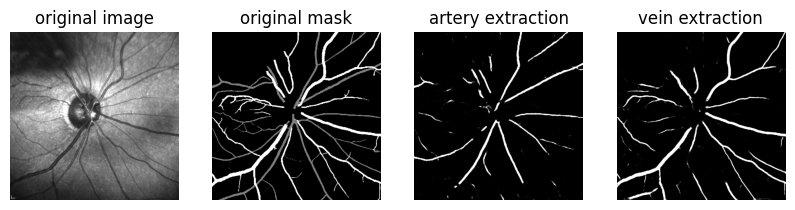

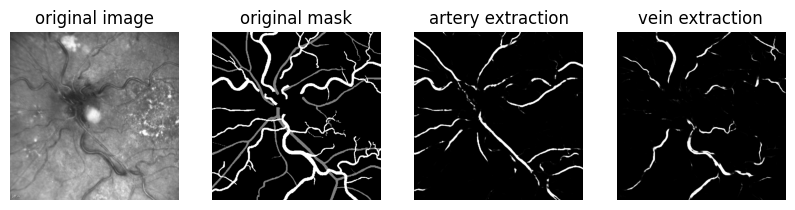

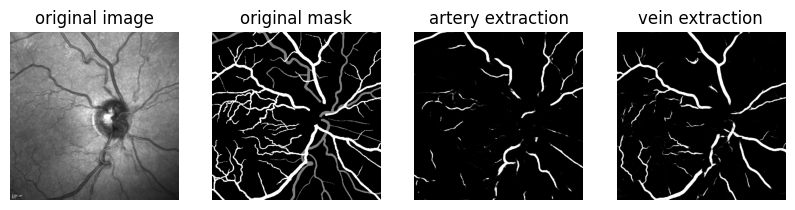

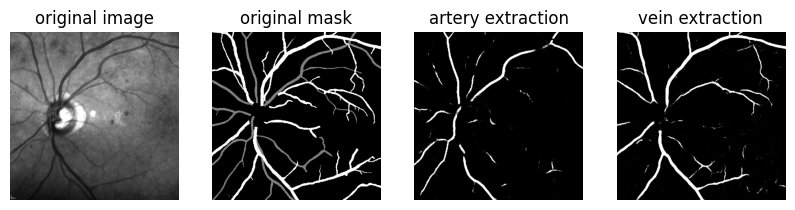

In [30]:
#save masks
create_dir('/content/drive/MyDrive/ravir_seg/results/3d_res4_resi/veins')
create_dir('/content/drive/MyDrive/ravir_seg/results/3d_res4_resi/bloodvess')

if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Load dataset """

    valid_x = sorted(glob("/content/drive/MyDrive/ravir_seg/data01/resz/test_no_aug/image/*"))
    valid_y = sorted(glob("/content/drive/MyDrive/ravir_seg/data01/resz/test_no_aug/mask/*"))

    """ Hyperparameters """
    H = 512
    W = 512
    size = (W, H)

    """ Load the checkpoint """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    binary_unet_1 = BinaryUNet().to(device)
    binary_unet = UNet_DeepComplex4().to(device)
    # Load the trained models
    binary_unet_1.load_state_dict(torch.load('/content/drive/MyDrive/ravir_seg/checkpoints/1stlayer_unet.pth'))
    binary_unet.load_state_dict(torch.load('/content/drive/MyDrive/ravir_seg/checkpoints/2ndlayer_unet.pth'))

    binary_unet_1.eval()
    binary_unet.eval()

    best_binary_loss = float('inf')
    best_binary_loss = float('inf')
    best_valid_loss = float("inf")

    valid_dataset = RavirDataset_2OP(valid_x, valid_y)

    valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=2,
        shuffle=False,
        num_workers=2
    )

    predicted_binary_masks = []
    predicted_binary_masks_v = []
    predicted_binary_masks_b = []
    recon_img=[]
    og_mask_v=[]
    og_mask_b=[]
    og_mask=[]
    og_image=[]

    with torch.no_grad():
      # Iterate over the test dataset and make predictions
      for image, tri_mask, mask_v,mask_b in valid_loader:
          image = image.to(device)
          og_image.append(image)
          og_image_cpu = [img.cpu() for img in og_image]
          og_image_np = [img.cpu().numpy() for img in og_image_cpu]

          mask_v = mask_v.to(device)
          og_mask_v.append(mask_v)
          og_mask_v_cpu = [img.cpu() for img in og_mask_v]
          og_mask_v_np = [img.cpu().numpy() for img in og_mask_v_cpu]

          mask_b = mask_b.to(device)
          og_mask_b.append(mask_b)
          og_mask_b_cpu = [img.cpu() for img in og_mask_b]
          og_mask_b_np = [img.cpu().numpy() for img in og_mask_b_cpu]

          tri_mask=tri_mask.to(device)
          og_mask.append(tri_mask)
          og_mask_cpu = [msk.cpu() for msk in og_mask]
          og_mask_np = [msk.cpu().numpy() for msk in og_mask_cpu]

          binary_output = binary_unet_1(image)
          binary_predictions = (binary_output > 0.5).float()

          binary_output_v,binary_output_b, recon = binary_unet(image, binary_predictions)

          binary_predictions_v=torch.sigmoid(binary_output_v)
          binary_predictions_b=torch.sigmoid(binary_output_b)

          recon_predictions = torch.argmax(recon, dim=1)

          predicted_binary_masks_v.append(binary_predictions_v.cpu().numpy())
          predicted_binary_masks_b.append(binary_predictions_b.cpu().numpy())
          recon_img.append(recon_predictions.cpu().numpy())


    # Concatenate the predicted masks
    predicted_binary_masks_v = np.concatenate(predicted_binary_masks_v, axis=0)
    predicted_binary_masks_b = np.concatenate(predicted_binary_masks_b, axis=0)
    recon_img=np.concatenate(recon_img, axis=0)

    og_image=np.concatenate(og_image_np, axis=0)
    og_mask=np.concatenate(og_mask_np, axis=0)

    # Loop over the predicted binary masks and binary masks
    for i, (binary_pred_v, binary_pred_b,recon_pred ,img,msk) in enumerate(zip(predicted_binary_masks_v, predicted_binary_masks_b,recon_img, og_image,og_mask)):
        # Convert the binary mask to a PIL Image
        # binary_pred_channel = binary_pred[0]  # Assuming the mask is represented using the first channel
        binary_pred_channel_v = binary_pred_v[0]
        binary_pred_channel_b = binary_pred_b[0]
        binary_pred_img_v = Image.fromarray((binary_pred_channel_v * 255).astype('uint8'), mode='L')
        binary_pred_img_v.save(f'/content/drive/MyDrive/ravir_seg/results/res4_resi/veins/predicted_v_{i}.png')
        binary_pred_img_b = Image.fromarray((binary_pred_channel_b * 255).astype('uint8'), mode='L')
        binary_pred_img_b.save(f'/content/drive/MyDrive/ravir_seg/results/res4_resi/bloodvess/predicted_bv_{i}.png')


        recon_pred_img = Image.fromarray((recon_pred * 255).astype('uint8'), mode='L')

        fig, axs = plt.subplots(1, 4, figsize=(10, 5))

        img_squeezed = img.squeeze()
        axs[0].imshow(img_squeezed, cmap='gray')
        axs[0].axis('off')
        axs[0].set_title('original image')


        msk_squeezed = msk.squeeze()
        axs[1].imshow(msk_squeezed, cmap='gray')
        axs[1].axis('off')
        axs[1].set_title('original mask')

        axs[2].imshow( binary_pred_img_v,cmap='gray')
        axs[2].set_title('artery extraction')
        axs[2].axis('off')

        axs[3].imshow(binary_pred_img_b,cmap='gray')
        axs[3].axis('off')
        axs[3].set_title('vein extraction')


        # Show the plot
        plt.show()


In [34]:
#FINDING ACCURACY FOR THE VEINS

# Read the binary images and ground truth images using OpenCV
image1 = cv2.imread('/content/drive/MyDrive/ravir_seg/results/res4_resi/bloodvess/predicted_bv_0.png', cv2.IMREAD_GRAYSCALE)
image1[image1<140]=0
image1[image1>=140]=1
image2 = cv2.imread('image2.png', cv2.IMREAD_GRAYSCALE)
mask = cv2.imread('/content/drive/MyDrive/ravir_seg/data01/resz/test_no_aug/mask/IR_Case_053.png', cv2.IMREAD_GRAYSCALE)
mask=mask/255.0
mask[mask==0]=0
mask[mask==1]=1
mask[(mask > 0) & (mask < 1)] = 0


TP = np.sum(np.logical_and(image1 == 1, mask == 1))
TN = np.sum(np.logical_and(image1 == 0, mask == 0))
FP = np.sum(np.logical_and(image1 == 1, mask == 0))
FN = np.sum(np.logical_and(image1 == 0, mask == 1))


accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
# Calculate Dice Index
dice_index = (2 * TP) / (2 * TP + FP + FN)

print(f"Dice Index: {dice_index:.4f}")


Accuracy: 0.9701
Precision: 0.8571
Recall: 0.7139
Dice Index: 0.7790


In [36]:
#FINDING ACCURACY FOR THE ARTERY

# Read the binary images and ground truth images using OpenCV
image1 = cv2.imread('/content/drive/MyDrive/ravir_seg/results/res4_resi/veins/predicted_v_0.png', cv2.IMREAD_GRAYSCALE)
image1[image1<140]=0
image1[image1>=140]=1
image2 = cv2.imread('image2.png', cv2.IMREAD_GRAYSCALE)
mask = cv2.imread('/content/drive/MyDrive/ravir_seg/data01/resz/test_no_aug/mask/IR_Case_053.png', cv2.IMREAD_GRAYSCALE)
mask=mask/255.0
mask[mask==0]=0
mask[mask==1]=0
mask[(mask > 0) & (mask < 1)] = 1


TP = np.sum(np.logical_and(image1 == 1, mask == 1))
TN = np.sum(np.logical_and(image1 == 0, mask == 0))
FP = np.sum(np.logical_and(image1 == 1, mask == 0))
FN = np.sum(np.logical_and(image1 == 0, mask == 1))


accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
# Calculate Dice Index
dice_index = (2 * TP) / (2 * TP + FP + FN)

print(f"Dice Index: {dice_index:.4f}")

Accuracy: 0.9687
Precision: 0.7743
Recall: 0.6598
Dice Index: 0.7125
